In [4]:
import sys
sys.path.append("../lropy")

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullLocator
import pandas as pd
import numpy as np
import seaborn as sb
import swifter
import pickle
from datetime import datetime as dt, timedelta

from pathlib import Path

In [6]:
from lropy.analysis.io import load_all_simulation_results, load_simulation_results
from lropy.analysis.io import pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.constants import JULIAN_DAY
from lropy.analysis.transform import cart2track

In [7]:
# (metadata, runs), id = pd.read_pickle("../results/light-2023-06-08T11-14-10-9183d/results.pkl"), "9183d"  # with a = 0.12, A = 15.38, Cr = 1.41, delayed thermal
# (metadata, runs), id = pd.read_pickle("../results/light-2023-06-08T22-18-15-6db85/results.pkl"), "6db85"  # with a = 0.20, A = 15.38, Cr = 1.41, delayed thermal
# (metadata, runs), id = pd.read_pickle("../results/light-2023-06-10T00-28-57-af84b/results.pkl"), "af84b"  # with a = 0.195, A = 11.52, Cr = 1.25, delayed thermal
(metadata, runs), id = pd.read_pickle("../results/light-2023-06-10T09-47-25-76a4b/results.pkl"), "76a4b"  # with a = 0.195, A = 11.52, Cr = 1.25, angle-based thermal

metadata["albedo_distribution_moon"] = metadata["albedo_distribution_moon"].replace({
    "DLAM1": "DLAM-1",
    "Constant": "constant"
})

# metadata = metadata.reset_index()
# runs = {}
# for row in metadata.itertuples():
#     runs[row.Index] = runs_unsorted[row.index]

results_folder = f"poster"
# results_folder = f"poster/{id}"

In [8]:
# results_base = Path("../results/light-2023-06-06T11-11-37-7a84a")
# metadata, runs = load_all_simulation_results(results_base, load_runs=True)

In [9]:
def get_orbit_start(n_orbit):
    # 83 min to start opposite of subsolar point
    return pd.to_datetime(dt(2010, 9, 26, 6) + timedelta(minutes=n_orbit*113) + timedelta(minutes=83), utc=True)

In [10]:
def get_orbit_number(time):
    time -= get_orbit_start(0)
    return (time.days * JULIAN_DAY + time.seconds) / (113 * 60)

In [11]:
orbit_steps = int(113 * 60 / 10)

In [12]:
metadata[["id", "use_solar_radiation", "use_moon_radiation", "albedo_distribution_moon", "target_type", "walltime_duration"]]

,id,use_solar_radiation,use_moon_radiation,albedo_distribution_moon,target_type,walltime_duration
1,2aa8c,True,True,constant,Paneled,53835.282476
2,ad3e2,True,False,,Paneled,3900.92329
3,62495,True,True,constant,Cannonball,43267.74368
4,883d9,True,False,,Cannonball,3916.577451
5,4b8b9,True,True,DLAM-1,Paneled,52306.191348
6,02331,True,True,DLAM-1,Cannonball,43175.878621
7,9ddcb,False,False,,Paneled,3904.942806


In [13]:
df_baseline = runs[int(metadata[metadata["use_solar_radiation"] == False].index[0])]

# Accelerations

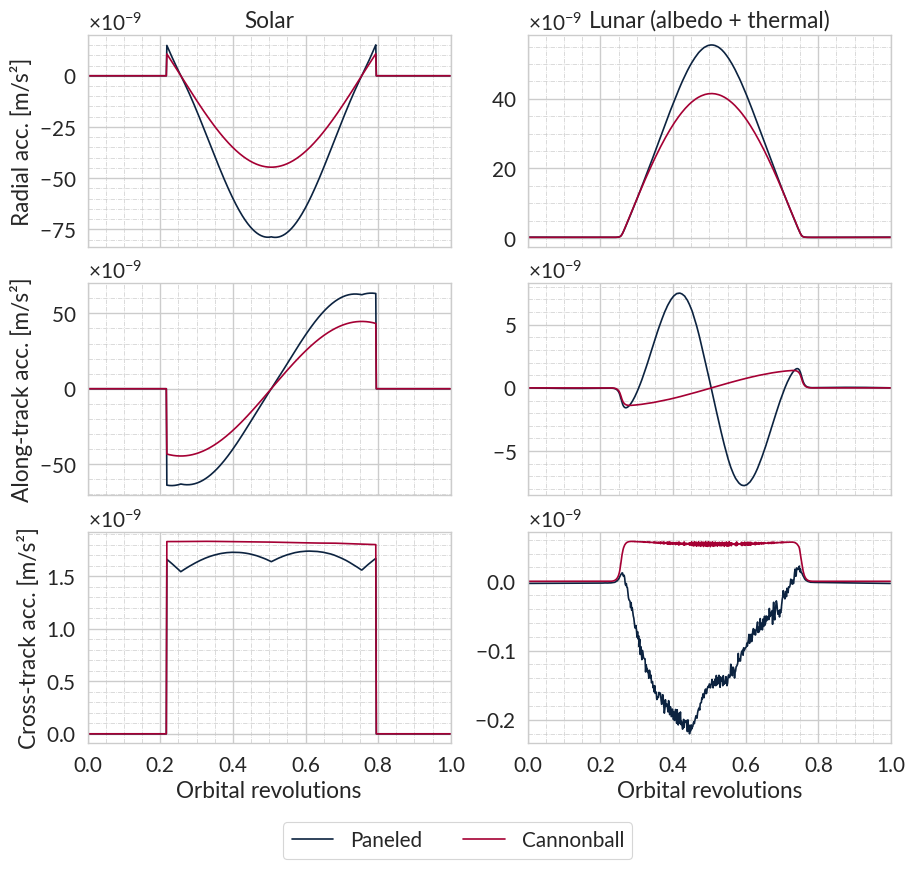

In [14]:
def plot_rp_accelerations(metadata):
    fig, axs = plt.subplots(3, 2, figsize=(9, 8.2), sharex="all")

    for i, row in enumerate(metadata.itertuples()):
        for j, source in enumerate(["sun", "moon"]):
            if not row.use_moon_radiation or row.albedo_distribution_moon == "constant":
                continue

            run = runs[row.Index]#.iloc[::50]
            run = run.iloc[(run.index >= get_orbit_start(21)) & (run.index <= get_orbit_start(22))]
            time = get_orbit_number(run.index) - 21

            ax_radial, ax_along, ax_cross = axs[:, j]
            if j == 0:
                # label = f"{row.target_type}, {row.albedo_distribution_moon}"
                label = f"{row.target_type}"
            else:
                label=None

            ax_radial.plot(time, run[f"acc_rp_{source}_radial"])
            ax_along.plot(time, run[f"acc_rp_{source}_along"])
            ax_cross.plot(time, run[f"acc_rp_{source}_cross"], label=label)
    
    fig.legend(bbox_to_anchor=(0.5, -0.08), loc="lower center", ncol=2)

    axs[0, 0].set_title("Solar")
    axs[0, 1].set_title("Lunar (albedo + thermal)")

    for ax in axs[-1, :].flat:
        # Last row
        ax.set_xlim([0, 1])
        ax.set_xlabel("Orbital revolutions")

    for ax, name in zip(axs[:, 0].flat, ["Radial", "Along-track", "Cross-track"]):
        # First column
        ax.set_ylabel(name + r" acc. [m/s²]")
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])
    
    format_plot()
    save_plot(results_folder, f"rp_acceleration")

plot_rp_accelerations(metadata)

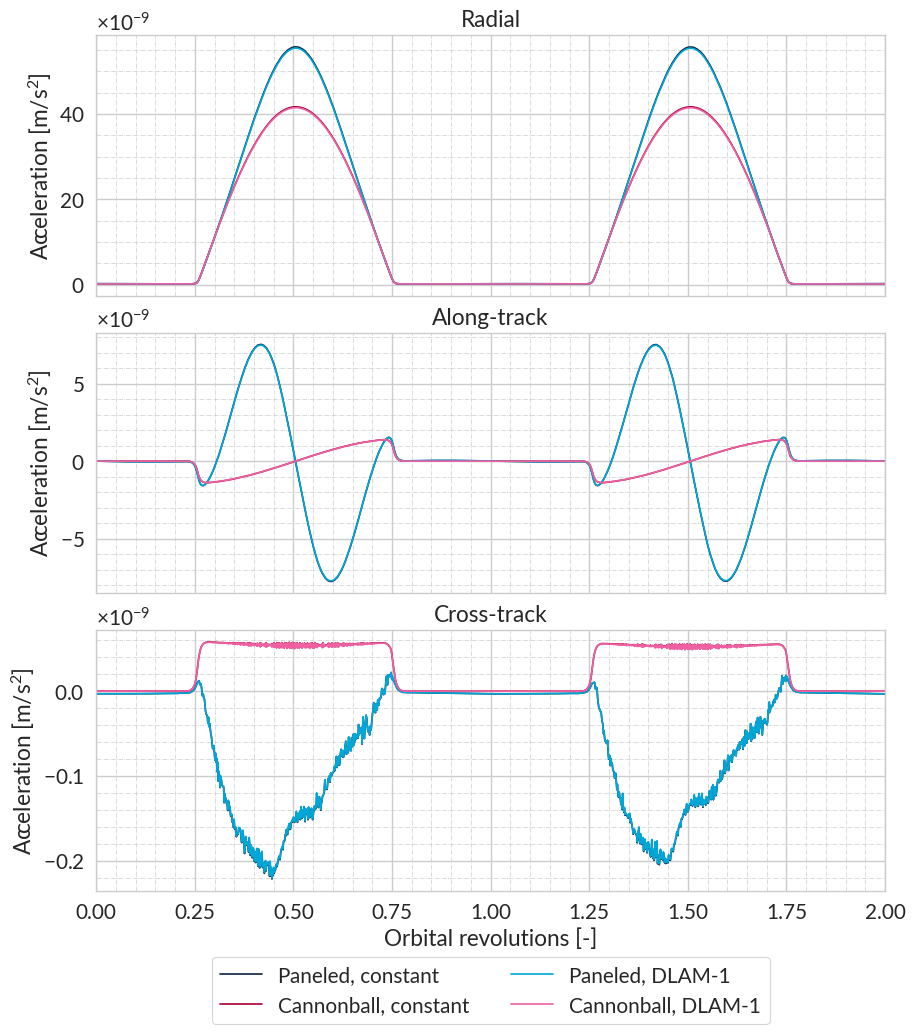

In [15]:
def plot_rp_accelerations_full(source: str):
    fig, axs = plt.subplots(3, figsize=(9, 10), sharex="all")
    ax_radial, ax_along, ax_cross = axs

    for row in metadata.itertuples():
        if not row.use_moon_radiation:
            continue

        run = runs[row.Index]
        run = run.iloc[(run.index >= get_orbit_start(21)) & (run.index <= get_orbit_start(23))]
        time = get_orbit_number(run.index) - 21

        if source == "both":
            acc_rp_radial = run["acc_rp_sun_radial"] + run[f"acc_rp_moon_radial"]
            acc_rp_along = run["acc_rp_sun_along"] + run[f"acc_rp_moon_along"]
            acc_rp_cross = run["acc_rp_sun_cross"] + run[f"acc_rp_moon_cross"]
        else:
            acc_rp_radial = run[f"acc_rp_{source}_radial"]
            acc_rp_along = run[f"acc_rp_{source}_along"]
            acc_rp_cross = run[f"acc_rp_{source}_cross"]

        ax_radial.plot(time, acc_rp_radial)
        ax_along.plot(time, acc_rp_along)
        ax_cross.plot(time, acc_rp_cross, label=f"{row.target_type}, {row.albedo_distribution_moon}")
    
    ax_cross.legend(bbox_to_anchor =(0.5,-0.55), loc="lower center", ncol=2)

    # fig.suptitle(source.title())
    ax_radial.set_title("Radial")
    ax_along.set_title("Along-track")
    ax_cross.set_title("Cross-track")

    # ax_cross.set_xlim([get_orbit_start(21), get_orbit_start(23)])
    ax_cross.set_xlim([0, 2])
    ax_cross.set_xlabel("Orbital revolutions [-]")
    for ax in axs:
        ax.set_ylabel(r"Acceleration [$m/s^2$]")
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
    
    format_plot()
    # fig.subplots_adjust(top=0.9)
    save_plot(results_folder, f"rp_{source}_acceleration")

plot_rp_accelerations_full("moon")

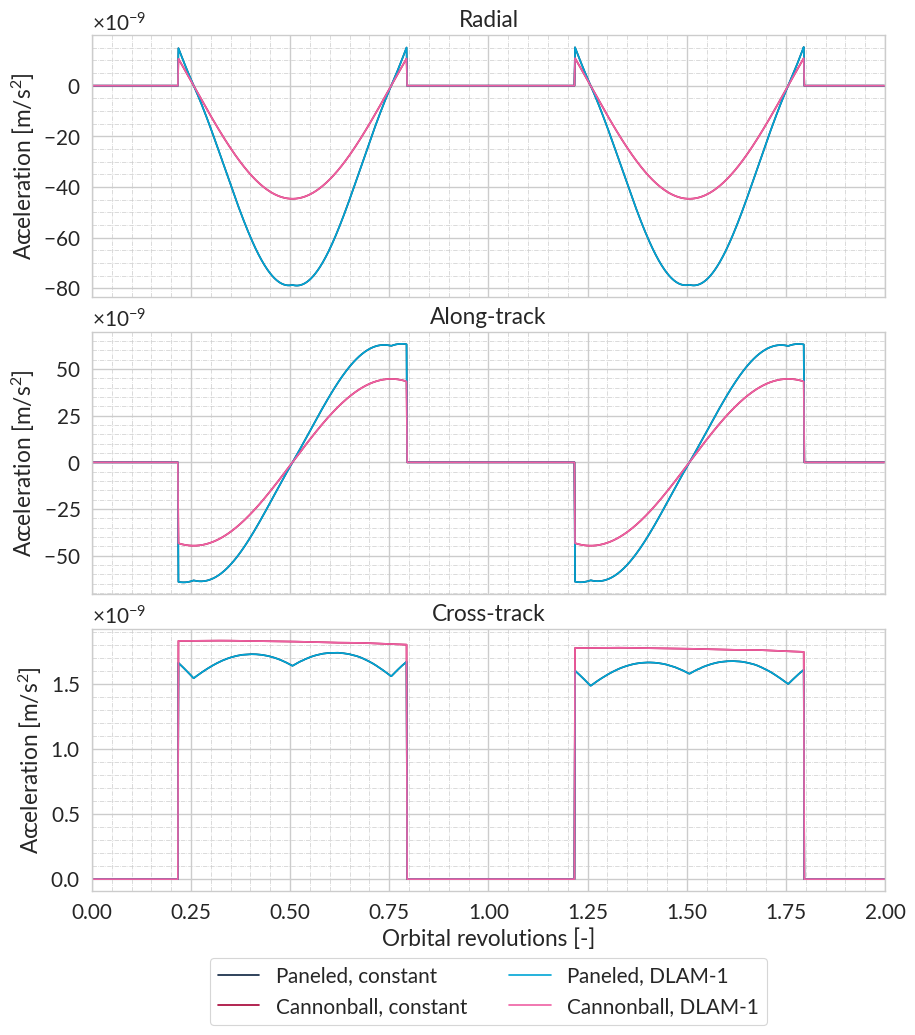

In [16]:
plot_rp_accelerations_full("sun")

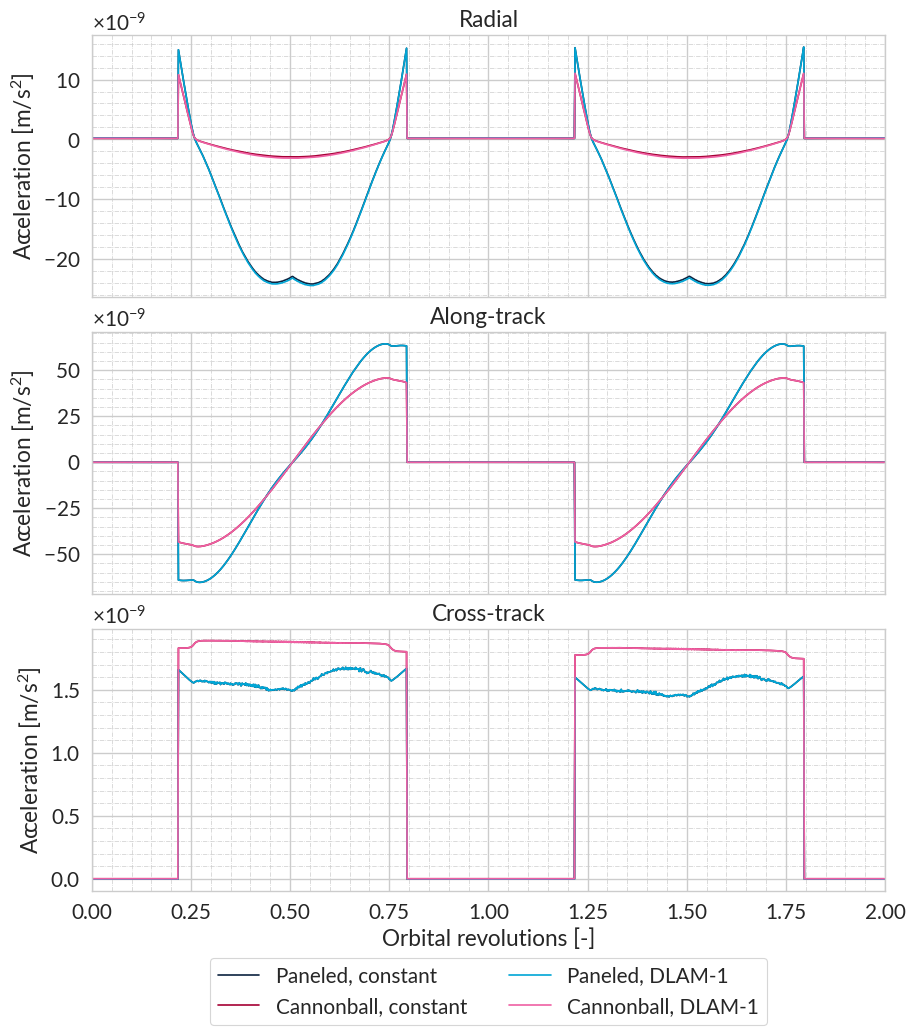

In [17]:
plot_rp_accelerations_full("both")

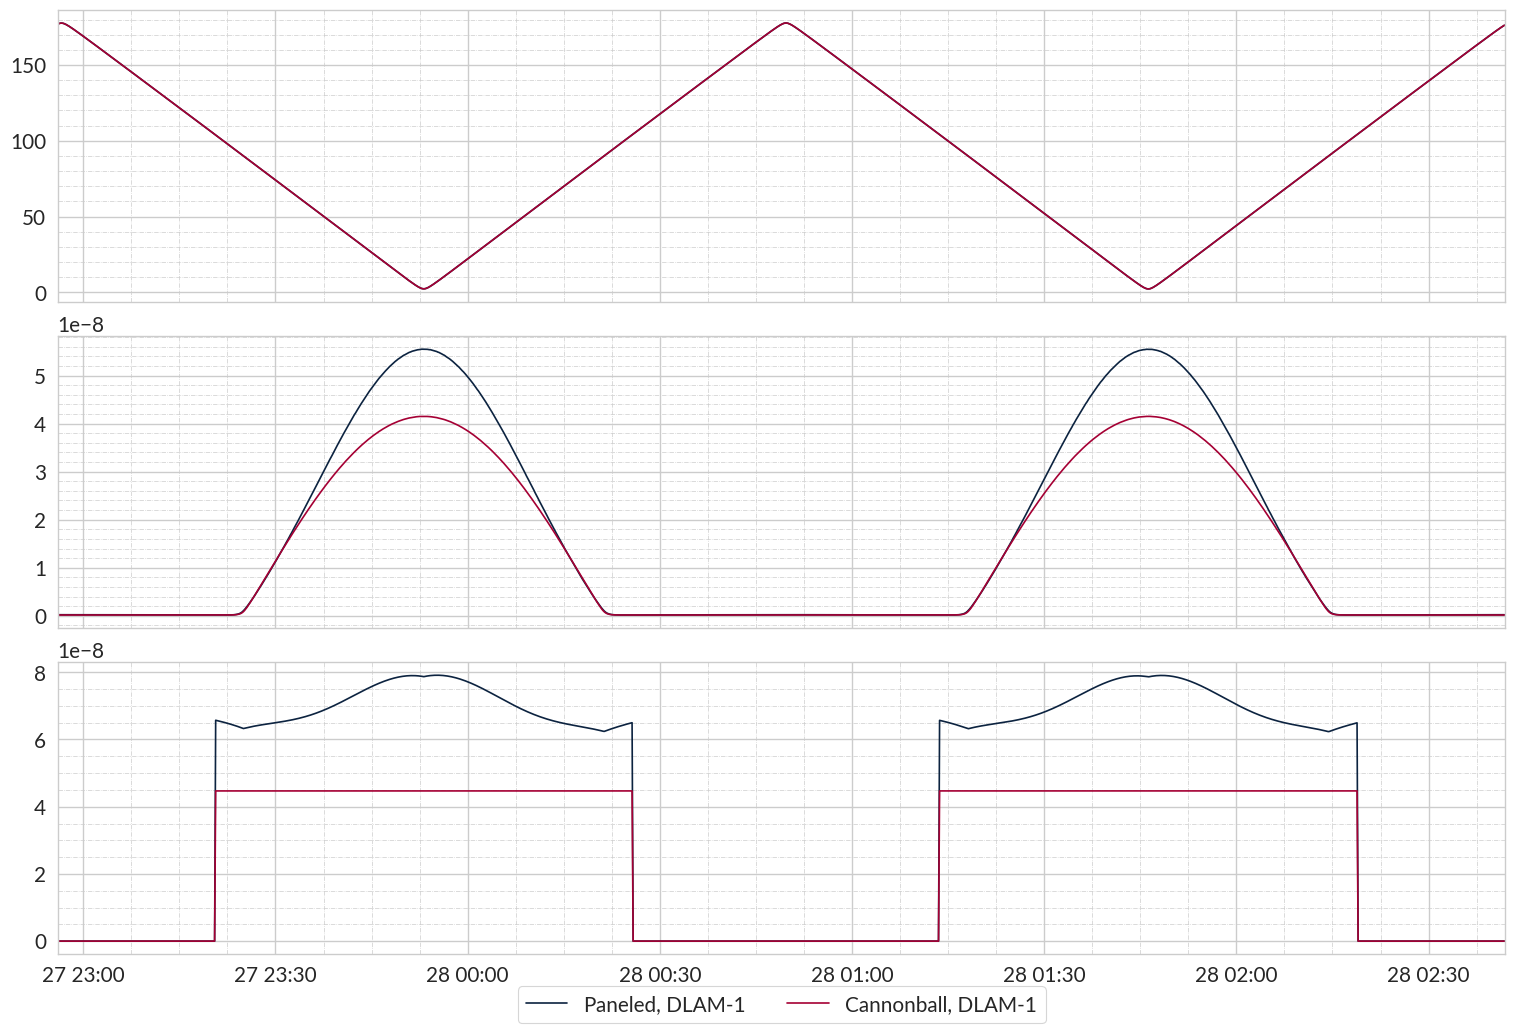

In [18]:
def plot_rp_accelerations_magnitude():
    fig, axs = plt.subplots(3, figsize=(15, 10), sharex="all")
    ax_subsolar, ax_moon, ax_sun = axs

    for row in metadata.itertuples():
        if not row.use_moon_radiation or row.albedo_distribution_moon == "constant":
            continue

        run = runs[row.Index]
        run = run.iloc[(run.index >= get_orbit_start(21)) & (run.index <= get_orbit_start(23))]

        ax_subsolar.plot(run.index, run["angle_subsolar"])
        ax_moon.plot(run.index, run["acc_rp_moon"])
        ax_sun.plot(run.index, run["acc_rp_sun"], label=f"{row.target_type}, {row.albedo_distribution_moon}")
    
    ax_sun.legend(bbox_to_anchor =(0.5,-0.27), loc='lower center', ncol=4)

    ax_sun.set_xlim([get_orbit_start(21), get_orbit_start(23)])
    for ax in axs:
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])

    format_plot()
    save_plot(results_folder, "rp_acc_mag")

plot_rp_accelerations_magnitude()

* When sun is occulted, only thermal radiation acts
* Local maximum in shadow for paneled model since solar arrays always point towards sun -> opposite of subsolar point, the point towards lunar surface
* mention occultation percentage

In [19]:
def calculate_occultation_percentage():
    df = runs[int(metadata[metadata["use_solar_radiation"] == True].index[0])]
    occ = (df["acc_rp_sun"] > 0).mean()
    print(f"Sun visible: {occ:.2%}   Sun occulted: {1-occ:.2%}")

calculate_occultation_percentage()

Sun visible: 57.60%   Sun occulted: 42.40%


# Kepler elements

In [20]:
def plot_property(prop, relative=True):
    plt.subplots(figsize=(12, 10))

    for row in metadata.iloc[:-1].itertuples():
        run = runs[row.Index]
        if relative:
            y = run[prop] - df_baseline[prop]
        else:
            y = run[prop]
        plt.plot(run.index, y, label=f"{row.target_type}, {row.albedo_distribution_moon or 'no moon'}")

    plt.legend(bbox_to_anchor =(0.5,-0.27), loc="lower center", ncol=3)
    plt.ylabel("$\Delta$ " + prop)
    
    format_plot()
    save_plot(results_folder, prop)

# plot_property("lat")
# plot_property("kepler_longAscNode")
# plot_property("angle_subsolar", relative=False)

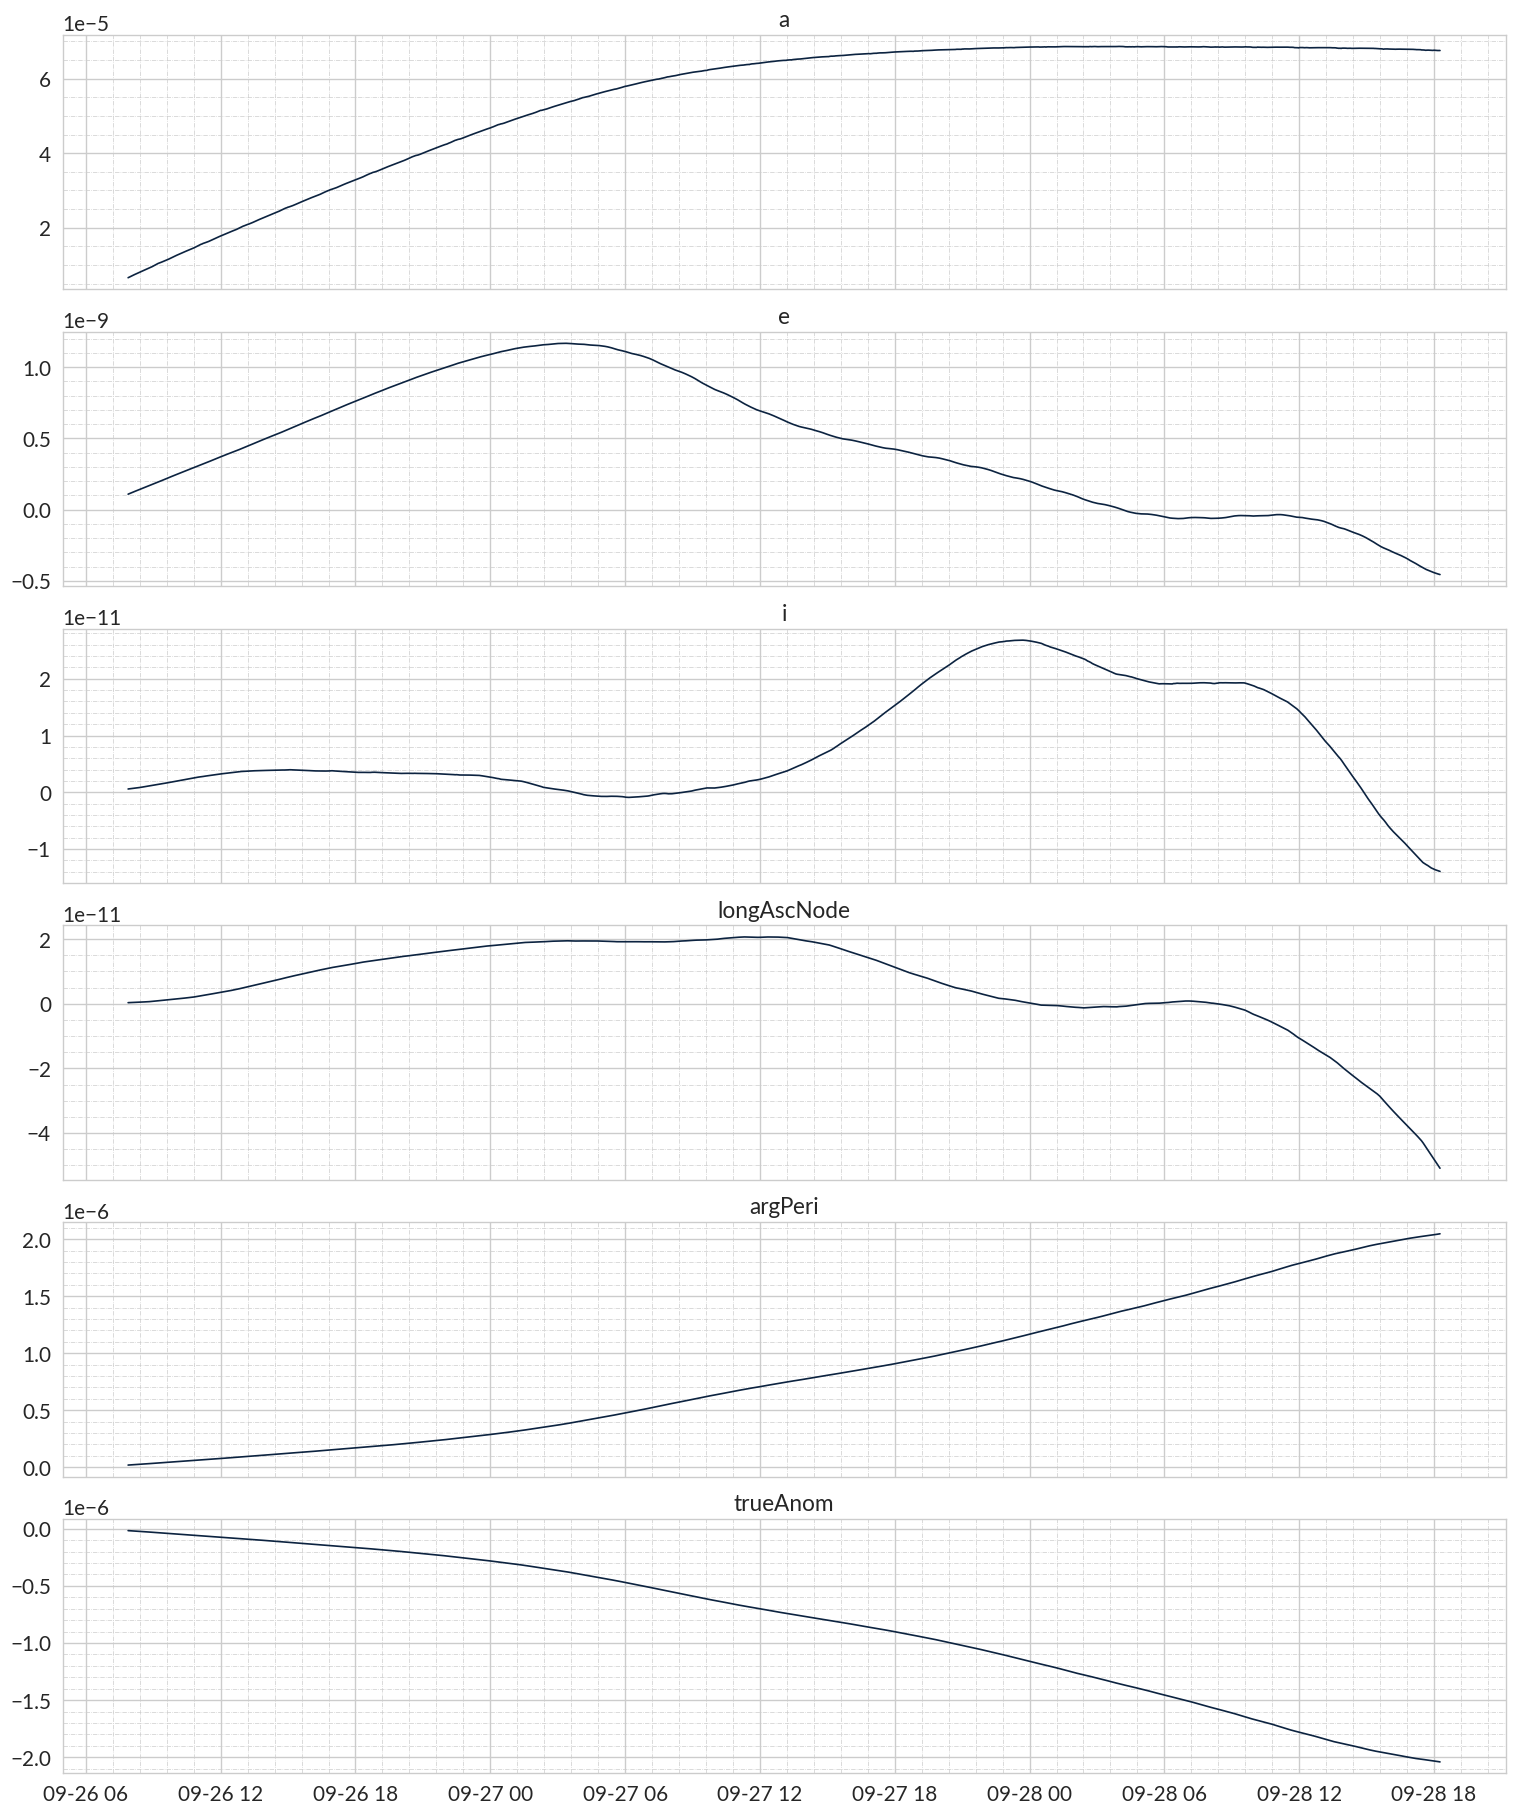

In [21]:
def plot_kepler_elements_cannonball():
    fig, axs = plt.subplots(6, figsize=(15, 6*3), sharex="all")

    names = ["a", "e", "i", "longAscNode", "argPeri", "trueAnom"]

    df_const = runs[
            metadata[
            (metadata["target_type"] == "Cannonball") &
            (metadata["albedo_distribution_moon"] == "constant")
        ].index[0]
    ]
    df_sh = runs[
            metadata[
            (metadata["target_type"] == "Cannonball") &
            (metadata["albedo_distribution_moon"] == "DLAM-1")
        ].index[0]
    ]

    for ax, name in zip(axs, names):
        y = df_sh[f"kepler_{name}"] - df_const[f"kepler_{name}"]
        ax.plot(y.index, y.rolling(orbit_steps).mean())
    
    for ax, name in zip(axs, names):
        ax.set_title(name)

    # axs[-1].set_xlim([dt(2010, 9, 27, 6), dt(2010, 9, 27, 6) + timedelta(minutes=3*113)])
    
    format_plot()
    save_plot(results_folder, "kepler_elements_cannonball")

plot_kepler_elements_cannonball()

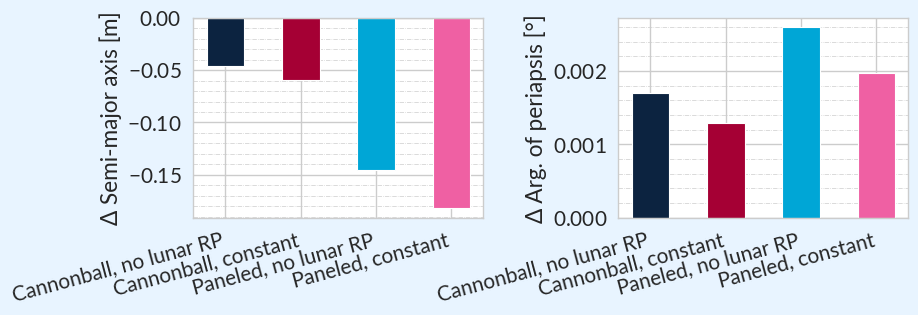

In [22]:
def plot_kepler_elements_final(df_baseline):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex="all", facecolor="#e8f4ff")
    ax_a, ax_argPeri = axs

    df_baseline = df_baseline.iloc[-1500:]

    df = []

    for row in metadata.itertuples():
        if not row.use_solar_radiation:
            continue
        if row.albedo_distribution_moon == "DLAM-1":
            continue

        run = runs[row.Index].iloc[-1500:]

        label = f"{row.target_type}, {row.albedo_distribution_moon or 'no lunar RP'}"

        df.append(
            {
                "label": label,
                "a": (run[f"kepler_a"] - df_baseline[f"kepler_a"]).rolling(orbit_steps).mean().iloc[-1],
                "argPeri": (run[f"kepler_argPeri"] - df_baseline[f"kepler_argPeri"]).rolling(orbit_steps).mean().iloc[-1]
            }
        )
    
    df = pd.DataFrame(df).sort_values("a", ascending=False).reset_index(drop=True)
    
    width = 0.5
    ax_a.bar(df.index, df["a"], color=sb.color_palette(), width=width)
    ax_a.set_ylabel("Δ Semi-major axis [m]")
    ax_a.set_xticks(df.index, df["label"], rotation=15, ha="right")
    
    ax_argPeri.bar(df.index, df["argPeri"], color=sb.color_palette(), width=width)
    ax_argPeri.set_ylabel("Δ Arg. of periapsis [°]")
    ax_argPeri.set_xticks(df.index, df["label"], rotation=15, ha="right")
    
    for ax in axs:
        ax.ticklabel_format(axis="y", style="sci", useMathText=True)

    format_plot(xlocator=NullLocator(), tight_layout=False)
    fig.tight_layout(pad=0.1, h_pad=0.4, w_pad=-2)
    save_plot(results_folder, "kepler_elements_final")

plot_kepler_elements_final(df_baseline)

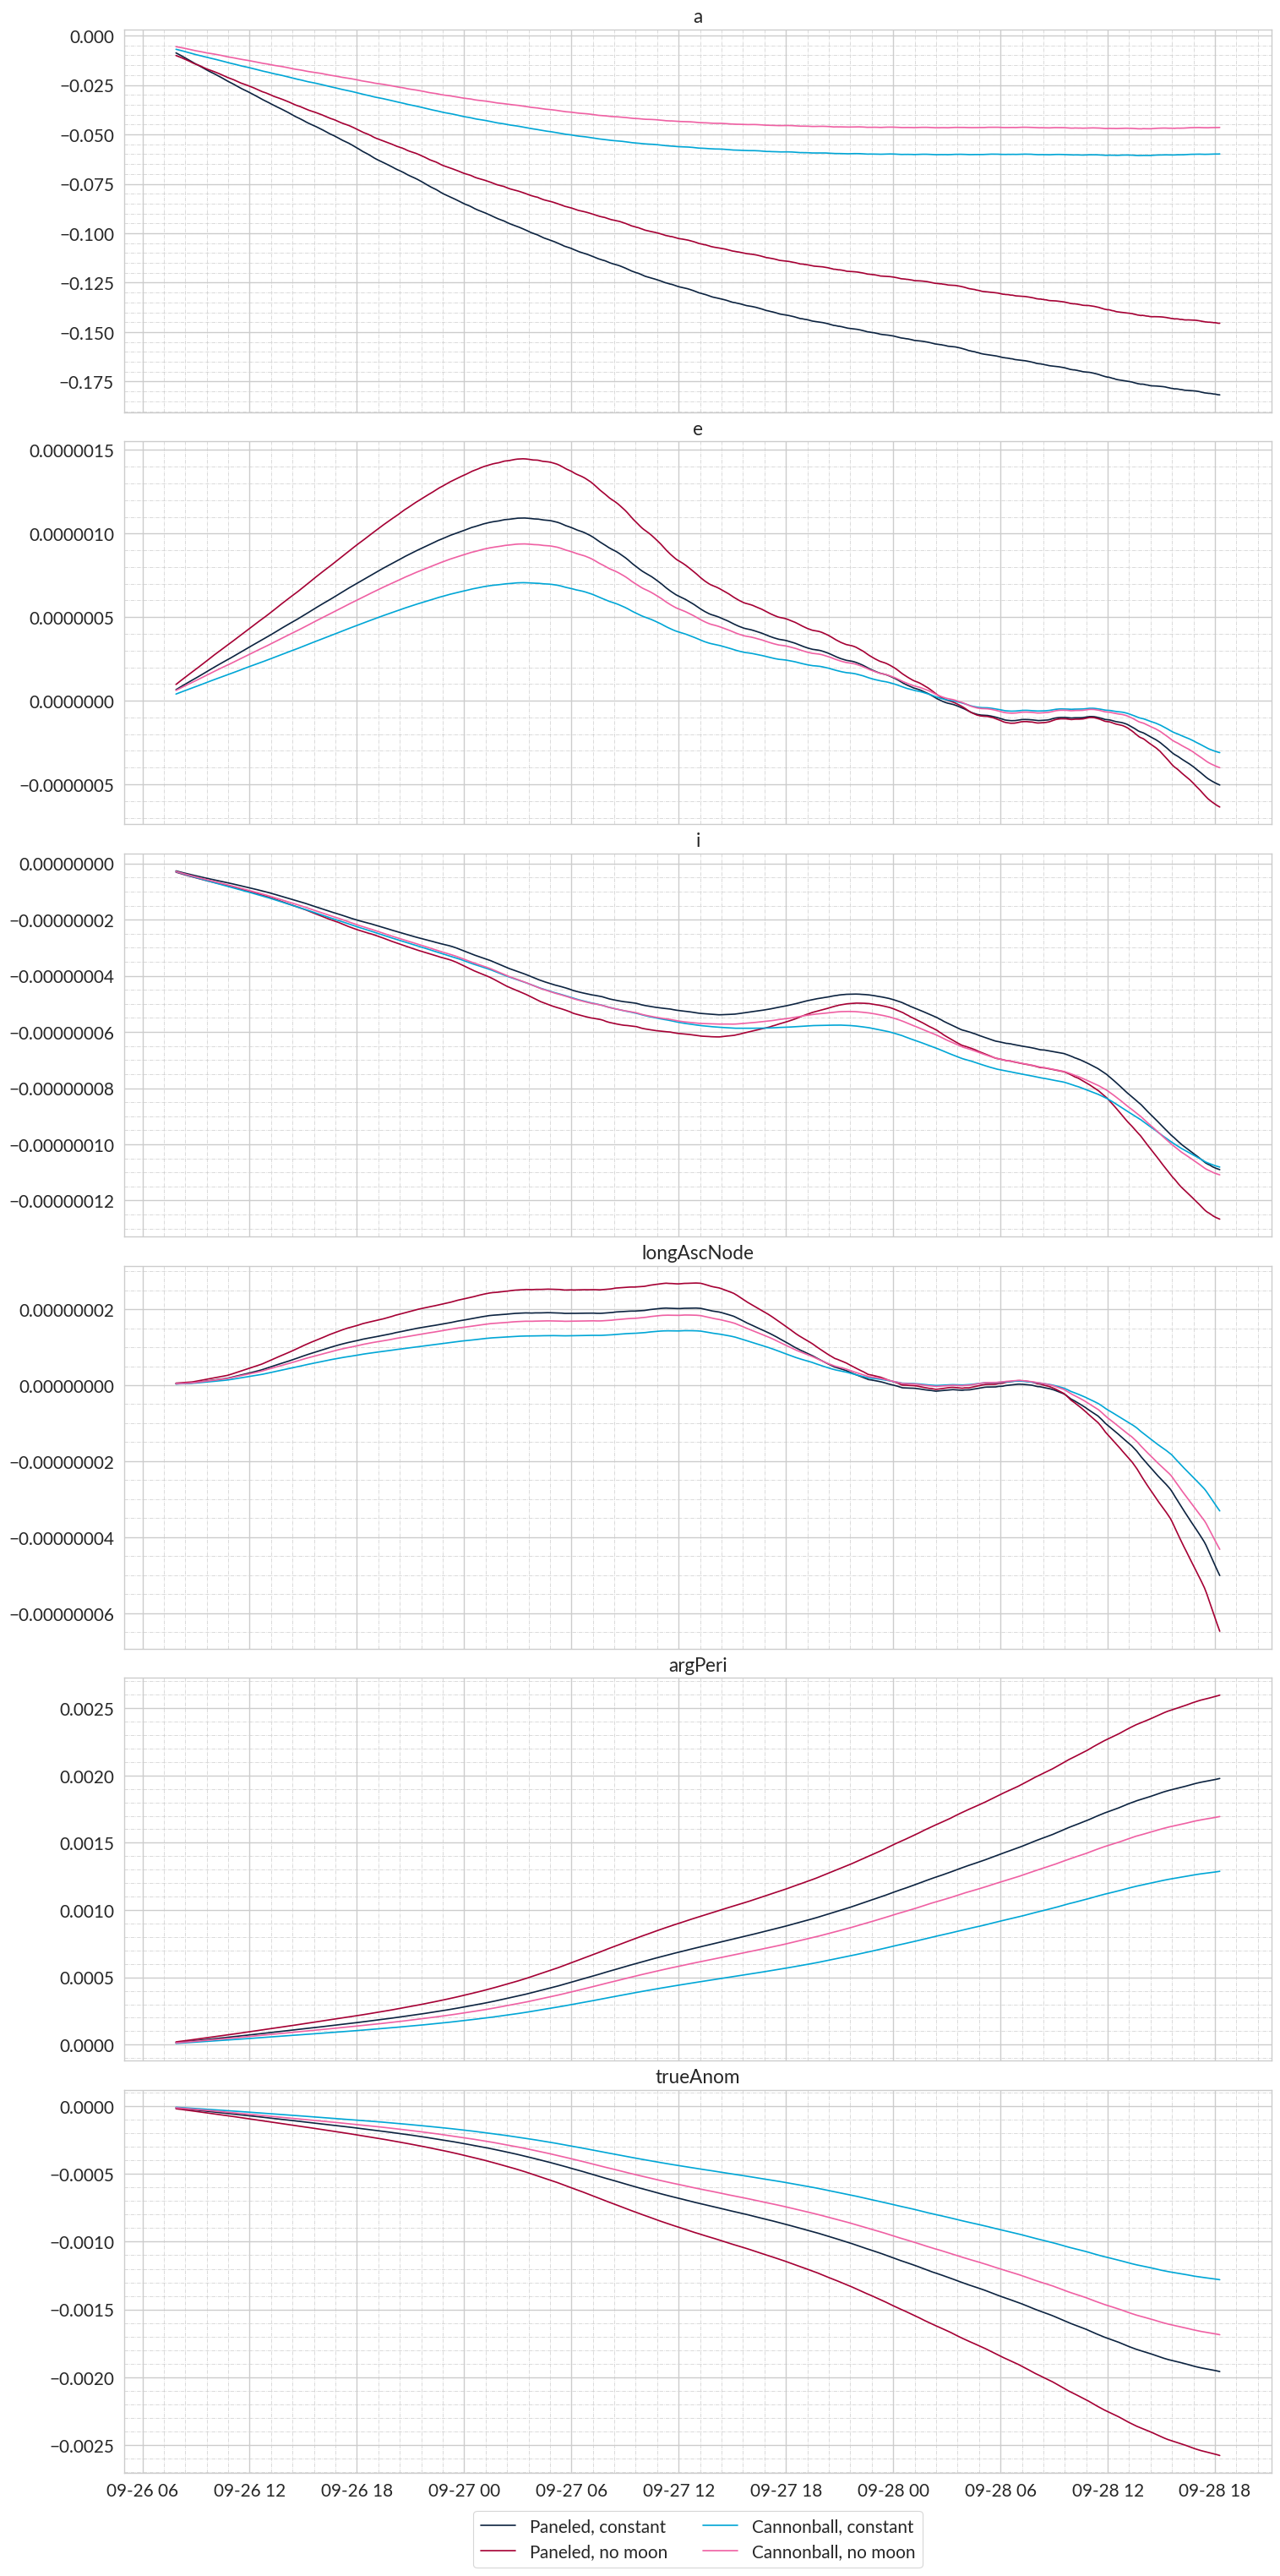

In [23]:
def plot_kepler_elements(df_baseline, mean=False, percent=False):
    fig, axs = plt.subplots(6, figsize=(15, 6*5), sharex="all")

    names = ["a", "e", "i", "longAscNode", "argPeri", "trueAnom"]

    df_baseline = df_baseline

    for row in metadata.itertuples():
        if not row.use_solar_radiation:
            continue
        if row.albedo_distribution_moon == "DLAM-1":
            continue

        run = runs[row.Index]

        for ax, name in zip(axs, names):
            y = run[f"kepler_{name}"] - df_baseline[f"kepler_{name}"]
            if percent:
                y *= 100 / df_baseline[f"kepler_{name}"]
                y = y[y < 100]
            else:
                y = y[y / df_baseline[f"kepler_{name}"] < 1]
            if mean:
                y = y.rolling(orbit_steps).mean()
            ax.plot(y.index, y, label=f"{row.target_type}, {row.albedo_distribution_moon or 'no moon'}")
    
    axs[-1].legend(bbox_to_anchor =(0.5,-0.27), loc="lower center", ncol=2)
    for ax, name in zip(axs, names):
        ax.set_title(name)
        ax.ticklabel_format(axis="y", style="plain")

    # axs[-1].set_xlim([dt(2010, 9, 27, 6), dt(2010, 9, 27, 6) + timedelta(minutes=3*113)])
    
    format_plot()

plot_kepler_elements(df_baseline, mean=True, percent=False)

all:
* Lunar radiation has little effect, mostly changes due to SRP
* Paneled much more affected than cannonball
* trend is negative as expected
* TO INVESTIGATE: _Cannonball experiences less variation__ (stays more centered)

a:
* paneled continues to diverge but cannonball has stable mean after 15 orbits
* paneled affected much more since it points towards sun
* ~15 cm change at end
* moon makes decrease of a larger
* would have expected to be reduced more due to net radial SRP + lunar

e:
* diverges in first 15 orbits, then converges
* moon reduces change in e
* should be increased by large radial RP acc only on solar side

i:
* barely any change since cross-track accelerations are small

long asc node:
* diverges in first 15 orbits, then converges

arg peri:
* Generally same behavior as a, continues to diverge since highly dependent on along-track acc

true anom:
* Generally same behavior as a, continues to diverge since highly dependent on along-track acc

divergent: a, arg peri, true anom
convergent: e, i, long asc node

# Position difference

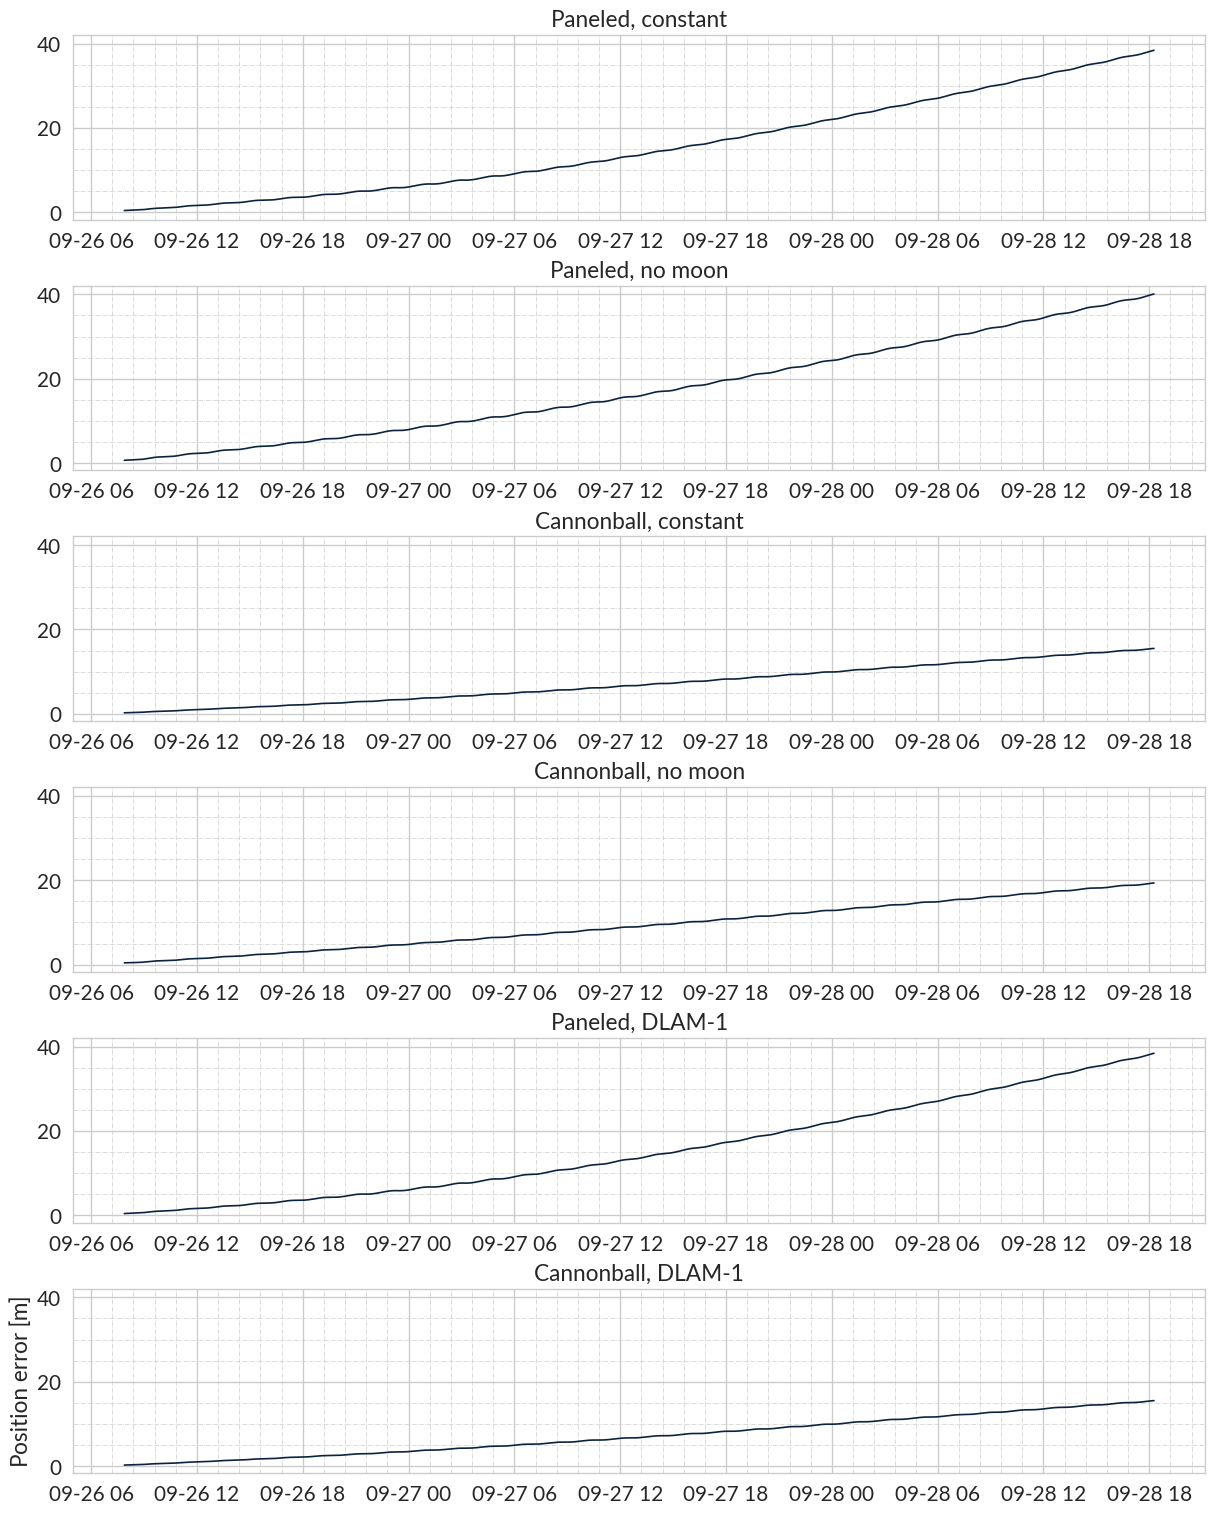

In [24]:
def plot_position_error():
    fig, axs = plt.subplots(6, figsize=(12, 15), sharey="all")

    for row, ax in zip(metadata.itertuples(), axs):
        if not row.use_solar_radiation:
            continue
        # if row.use_moon_radiation:
        #     continue
        # if row.target_type == "Paneled":
        #     continue

        run = runs[row.Index]

        error = run[pos_names] - df_baseline[pos_names]
        error["total"] = np.sqrt(np.square(error).sum(axis=1)).rolling(orbit_steps).mean()
        
        ax.set_title(f"{row.target_type}, {row.albedo_distribution_moon or 'no moon'}")
        ax.plot(error.index, error["total"])

    plt.ylabel("Position error [m]")
    
    format_plot()
    save_plot(results_folder, "position_error")

plot_position_error()

* Moon reduces position drift since it opposes radial radiation

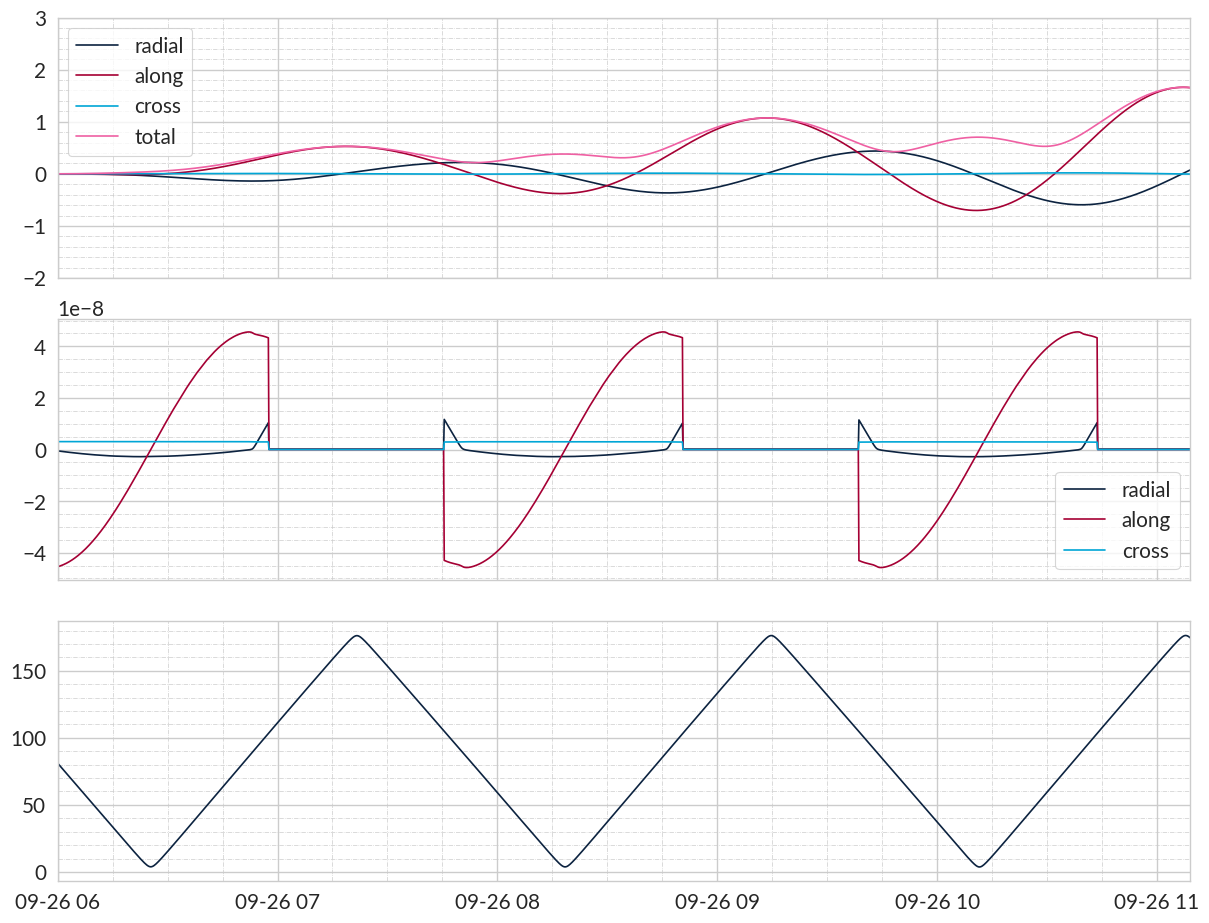

In [25]:
def plot_error_and_angle(target_type):
    run = runs[
            metadata[
            (metadata["target_type"] == target_type) &
            (metadata["albedo_distribution_moon"] == "constant")
        ].index[0]
    ]

    error_names = [f"error_{name}" for name in pos_names]

    error = run[pos_names] - df_baseline[pos_names]
    error.columns = error_names
    error[pos_names] = df_baseline[pos_names]
    error[vel_names] = df_baseline[vel_names]

    def error_components(row):
        pos = row[pos_names].to_numpy()
        vel = row[vel_names].to_numpy()
        err = row[error_names].to_numpy()
        row["error_radial"], row["error_along"], row["error_cross"] = cart2track(err, vel, pos)
        return row

    error = error.apply(error_components, axis=1)
    error["total"] = np.linalg.norm(error[error_names], axis=1)

    error_mean = error.rolling(orbit_steps).mean()
    variances = error.iloc[-orbit_steps:] - error_mean.iloc[-orbit_steps:]

    fig, (ax_pos, ax_acc, ax_angle) = plt.subplots(3, figsize=(12, 9), sharex="all")
    ax_pos.plot(error.index, error["error_radial"], label="radial")
    ax_pos.plot(error.index, error["error_along"], label="along")
    ax_pos.plot(error.index, error["error_cross"], label="cross")
    ax_pos.plot(error.index, error["total"], label="total")
    ax_pos.legend()

    ax_acc.plot(run.index, run["acc_rp_moon_radial"] + run["acc_rp_sun_radial"], label="radial")
    ax_acc.plot(run.index, run["acc_rp_moon_along"] + run["acc_rp_sun_along"], label="along")
    ax_acc.plot(run.index, run["acc_rp_moon_cross"] + run["acc_rp_sun_cross"], label="cross")
    ax_acc.legend()

    ax_angle.plot(df_baseline.index, run["angle_subsolar"])

    ax_pos.set_ylim([-2, 3])
    ax_angle.set_xlim([get_orbit_start(0)-timedelta(minutes=83), get_orbit_start(2)])

    # ax_angle.set_xlim([get_orbit_start(25), get_orbit_start(27)])

    format_plot()
    save_plot(results_folder, "error_and_angle")

plot_error_and_angle("Cannonball")

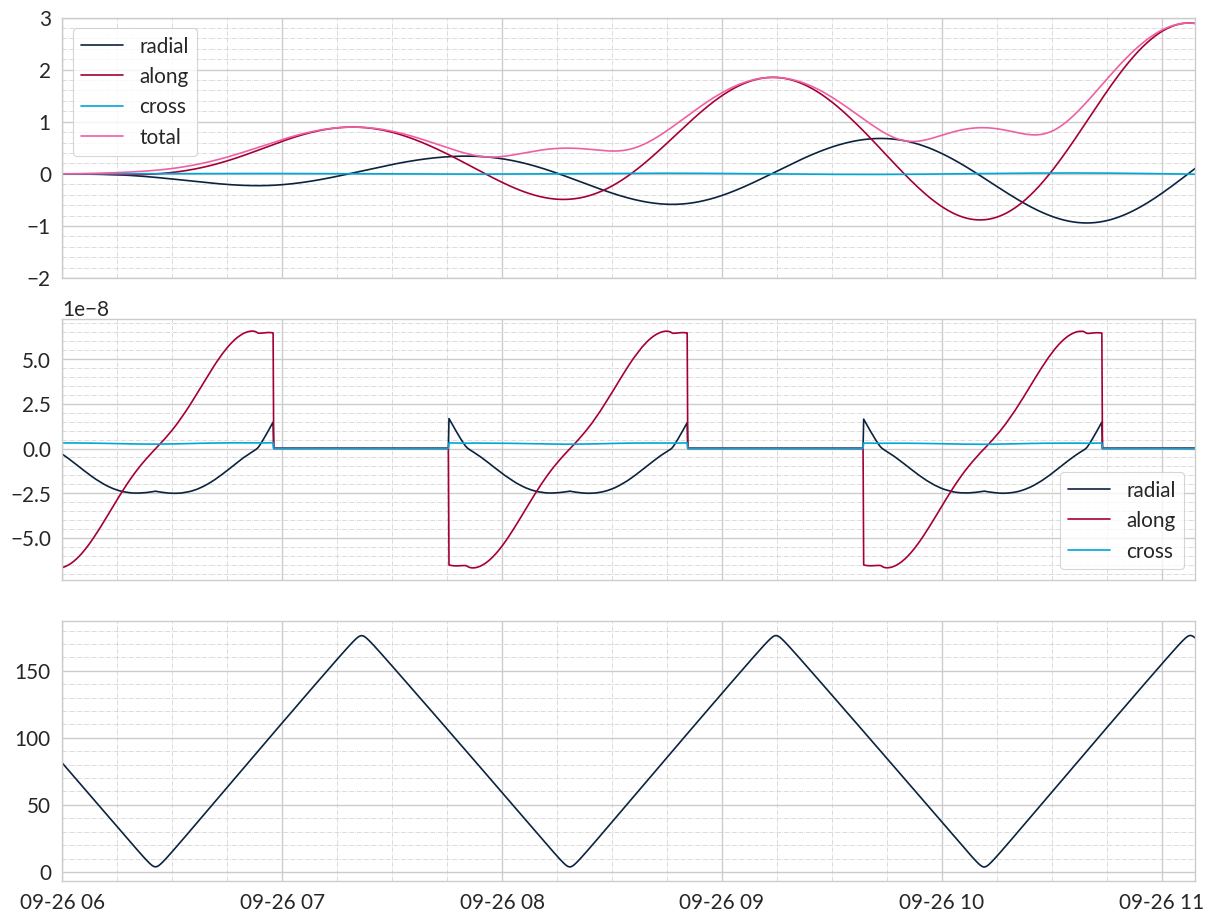

In [26]:
plot_error_and_angle("Paneled")

* Radial error has negative trend when radial acceleration (which is almost always negative) acts
* Do accelerations and position error agree? E.g., net radial acc is always negative, why is radial error also positive? Is it due to inertia so that it overshoots on the backside (essentially eccentricity)?

In [27]:
def get_error_dfs():
    df_cannonball = []
    df_paneled = []

    for row in metadata.itertuples():
    # for row in metadata.iloc[3:5].itertuples():
        if not row.use_solar_radiation:
            continue

        # Only use last 2 orbits since we are interested in the final error
        run = runs[row.Index].iloc[-1500:]

        error_names = [f"error_{name}" for name in pos_names]

        error = run[pos_names] - df_baseline.iloc[-1500:][pos_names]
        error.columns = error_names
        error[pos_names] = df_baseline.iloc[-1500:][pos_names]
        error[vel_names] = df_baseline.iloc[-1500:][vel_names]

        def error_components(row):
            pos = row[pos_names].to_numpy()
            vel = row[vel_names].to_numpy()
            err = row[error_names].to_numpy()
            row["error_radial"], row["error_along"], row["error_cross"] = cart2track(err, vel, pos)
            return row

        error = error.apply(error_components, axis=1)
        error["total"] = np.linalg.norm(error[error_names], axis=1)
        error_mean = error.rolling(orbit_steps).mean()
        variances = error.iloc[-orbit_steps:] - error_mean.iloc[-orbit_steps:]

        if row.target_type == "Paneled":
            df = df_paneled
        else:
            df = df_cannonball

        df.append({
            "label": f"{row.target_type}, {row.albedo_distribution_moon or 'no lunar RP'}",
            "e_total": error["total"].iloc[-1],
            "e_total_min": variances["total"].min(),
            "e_total_max": variances["total"].max(),
            "e_radial": error_mean["error_radial"].iloc[-1],
            "e_radial_min": variances["error_radial"].min(),
            "e_radial_max": variances["error_radial"].max(),
            "e_along": error_mean["error_along"].iloc[-1],
            "e_along_min": variances["error_along"].min(),
            "e_along_max": variances["error_along"].max(),
            "e_cross": error_mean["error_cross"].iloc[-1],
            "e_cross_min": variances["error_cross"].min(),
            "e_cross_max": variances["error_cross"].max(),
        })
    
    df_cannonball = pd.DataFrame(df_cannonball).sort_values("e_total").reset_index(drop=True)
    df_paneled = pd.DataFrame(df_paneled).sort_values("e_total").reset_index(drop=True)

    return df_cannonball, df_paneled

df_cannonball, df_paneled = get_error_dfs()

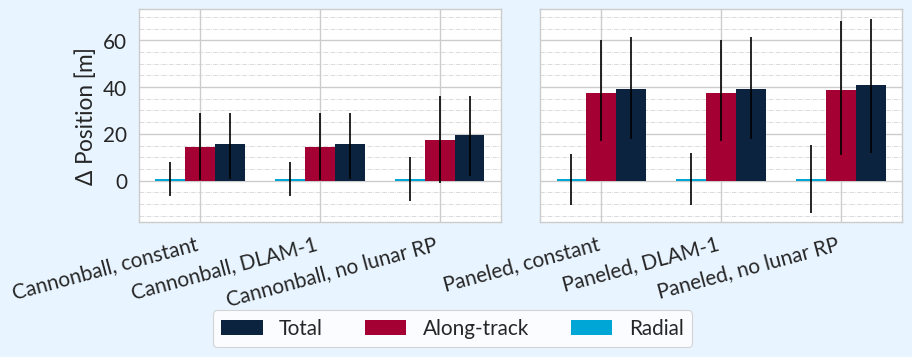

In [28]:
def plot_final_position_error():
    fig, (ax_cannonball, ax_paneled) = plt.subplots(1, 2, figsize=(9, 3), sharey="all", facecolor="#e8f4ff")

    width = 0.25

    # for j, (ax, df) in enumerate(zip([ ax_paneled], [ df_paneled])):
    for j, (ax, df) in enumerate(zip([ax_cannonball, ax_paneled], [df_cannonball, df_paneled])):
       df = pd.DataFrame(df).sort_values("e_total").reset_index(drop=True)
       ax.bar(df.index + 2 * width, df["e_total"], width,
              yerr=df[["e_total_min", "e_total_max"]].abs().to_numpy().T, linewidth=0, label="Total" if j == 0 else None)
       ax.bar(df.index + 1 * width, df["e_along"], width,
              yerr=df[["e_along_min", "e_along_max"]].abs().to_numpy().T, linewidth=0, label="Along-track" if j == 0 else None)
       ax.bar(df.index + 0 * width, np.maximum(0.6, df["e_radial"]), width,
              yerr=df[["e_radial_min", "e_radial_max"]].abs().to_numpy().T, linewidth=0, label="Radial" if j == 0 else None)
       # print(df["e_radial"])
       # print(df["e_radial_min"])
       # print(df["e_radial_max"])
        
       ax.set_xticks(df.index + width, df["label"], rotation=15, ha="right")

    ax_cannonball.set_ylabel("Δ Position [m]")
    fig.legend(bbox_to_anchor=(0.5, -0.16), loc="lower center", ncol=3)
    
    format_plot(xlocator=NullLocator(), tight_layout=False)
    fig.tight_layout(pad=0.0, h_pad=0.4, w_pad=-3)
    save_plot(results_folder, "final_position_error")

plot_final_position_error()

# Walltime

 29%|██▊       | 2/7 [00:00<00:00, 16.68it/s]

100%|██████████| 7/7 [00:00<00:00,  7.32it/s]


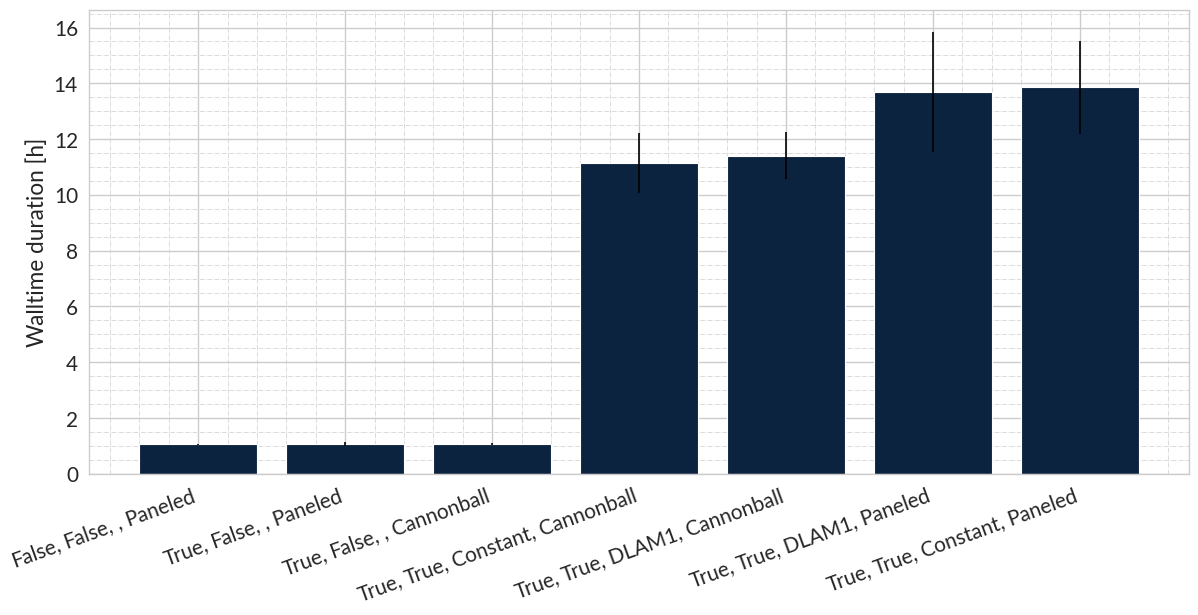

In [29]:
def summarize_walltime():
    experiments = [
        # "light-2023-06-08T11-14-10-9183d",  # empty server, 40000 panels
        "light-2023-06-08T22-18-15-6db85",  # empty server, 70000 panels
        "light-2023-06-10T00-28-57-af84b",  # server at 100%, 70000 panels
    ]
    metadata = [load_all_simulation_results(f"../results/{experiment}") for experiment in experiments]
    metadata = [
        m.sort_values(["use_solar_radiation", "use_moon_radiation", "target_type", "albedo_distribution_moon"])
         [["use_solar_radiation", "use_moon_radiation", "albedo_distribution_moon", "target_type", "walltime_duration"]]
           for m in metadata]

    metadata = pd.concat(metadata).groupby(["use_solar_radiation", "use_moon_radiation", "albedo_distribution_moon", "target_type"])
    metadata_mean = metadata.mean()
    metadata_mean["std"] =  metadata.std()
    # metadata_mean.columns = [' '.join(col).strip() for col in metadata_mean.columns.values]
    metadata_mean.index = metadata_mean.index.map(lambda x: ', '.join(map(str, x)))
    metadata_mean = metadata_mean.sort_values("walltime_duration")
    metadata_mean /= 3600

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(metadata_mean.index)), metadata_mean["walltime_duration"], yerr=metadata_mean["std"])
    ax.set_xticks(range(len(metadata_mean.index)), metadata_mean.index, rotation=20, ha="right")
    ax.set_ylabel("Walltime duration [h]")

    format_plot()
    

summarize_walltime()